# Lab: XAI and Uncertainty for Time-Series Forecasting (Panama Load)

You are data scientists at a grid operator in Panama. Your task is short-term load forecasting, interpreting model behaviour (XAI), and estimating predictive uncertainty so operators can make safer operational decisions. This notebook walks you through EDA, feature engineering, training a model, SHAP explanations, temporal attribution with occlusion, bootstrap-based variability, and conformal prediction intervals.

Follow the TODO markers in code cells. The dataset is expected at `data/panama_load.csv` and should contain at least a timestamp column and a load column. Optional covariates (temperature, humidity, etc.) are welcome.

In [2]:
# Section 0 - Setup
# Imports, plotting style, and random seed
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf 
import shap
import warnings
warnings.filterwarnings('ignore')

# Plot style and seed
sns.set_style('whitegrid')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

c:\Users\peper\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Section 1 — Load data and basic EDA

Goal: understand the time series, inspect seasonality, and spot anomalies. Follow instructions and fill TODOs.

You can learn more about the dataset at: https://www.kaggle.com/datasets/saurabhshahane/electricity-load-forecasting

In [3]:
# 1) Load data into a DataFrame
path = '../data/panama_load.csv'
if not os.path.exists(path):
    print(f'WARNING: {path} not found. Please place the dataset at this path.')
df = pd.read_csv(path)
print(f'Data loaded with shape: {df.shape}')

Data loaded with shape: (48048, 17)


In [4]:
datetime_col = 'datetime' 
load_col = 'nat_demand'  
# Attempt to parse a datetime column robustly
if datetime_col not in df.columns:
    # try to guess a datetime-like column
    for c in df.columns:
        if 'date' in c.lower() or 'time' in c.lower():
            datetime_col = c
            break
print('Using datetime column:', datetime_col)
# Parse datetimes
try:
    df[datetime_col] = pd.to_datetime(df[datetime_col])
except Exception as e:
    print('Error parsing datetimes:', e)
# Set index and sort
df = df.set_index(datetime_col).sort_index()

print('Using load column:', load_col)
# Keep a clean dataframe with at least datetime index and load
data = df[[load_col]].copy()
data.columns = ['load']
data = data.sort_index()
data.head()

Using datetime column: datetime
Using load column: nat_demand


,load
datetime,
2015-01-03 01:00:00,970.3450
2015-01-03 02:00:00,912.1755
2015-01-03 03:00:00,900.2688
2015-01-03 04:00:00,889.9538
2015-01-03 05:00:00,893.6865


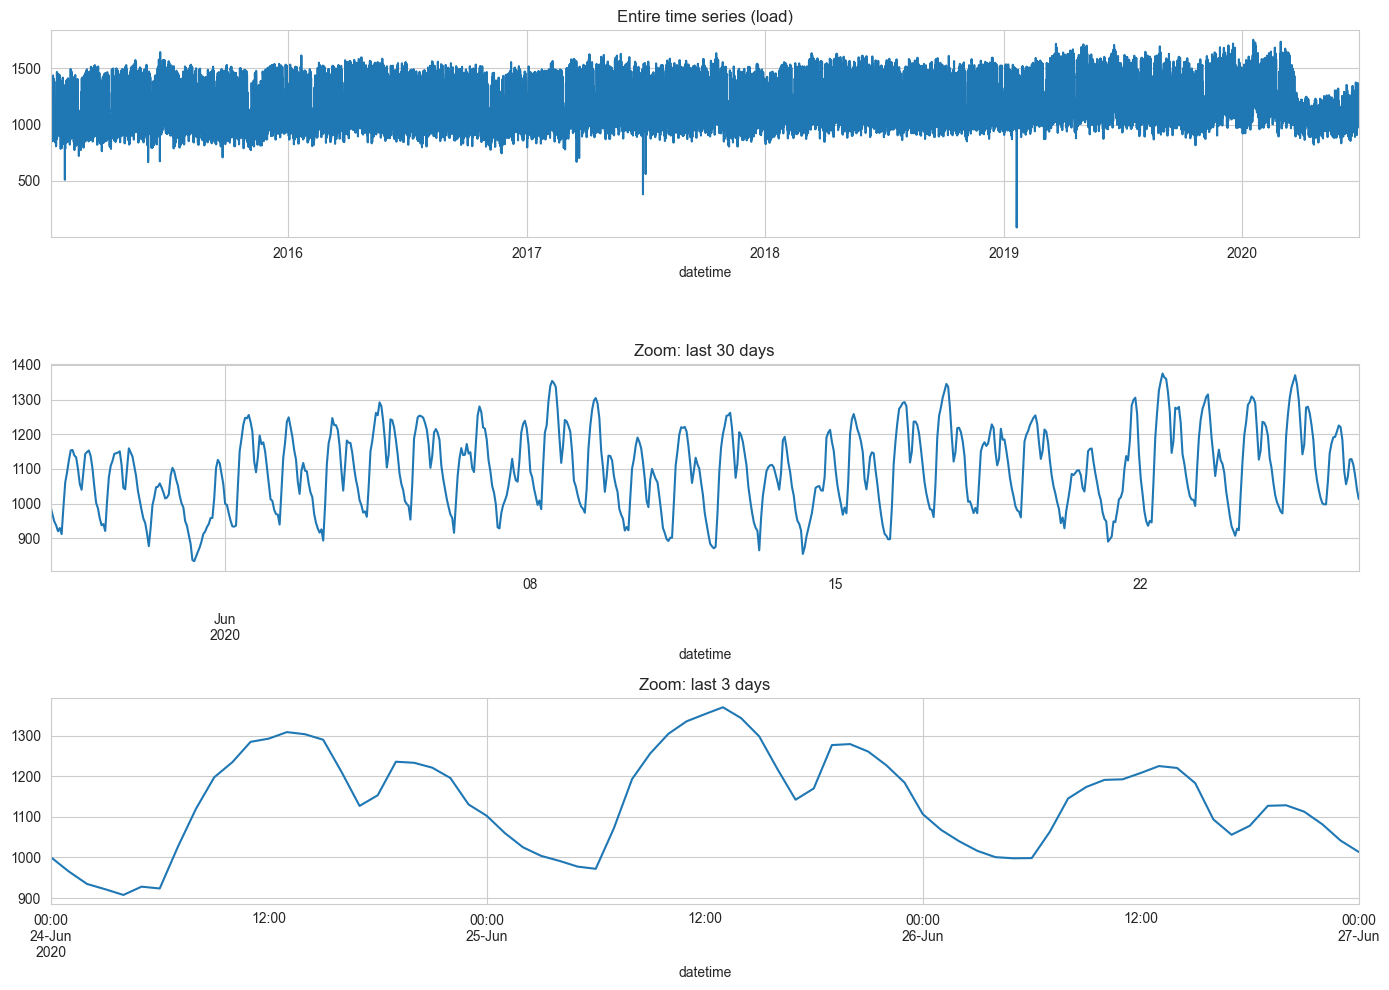

In [5]:
# 2) Basic plots: entire series, one month, a couple of days
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
# Entire series
data['load'].plot(ax=ax[0], title='Entire time series (load)')
# Zoom into one month (choose the last available month)
last = data.index.max()
month_start = (last - pd.Timedelta(days=30)).ceil('D')
data.loc[month_start:last, 'load'].plot(ax=ax[1], title='Zoom: last 30 days')
# Zoom into a couple of days
days_start = (last - pd.Timedelta(days=3)).ceil('D')
data.loc[days_start:last, 'load'].plot(ax=ax[2], title='Zoom: last 3 days')
plt.tight_layout()
plt.show()

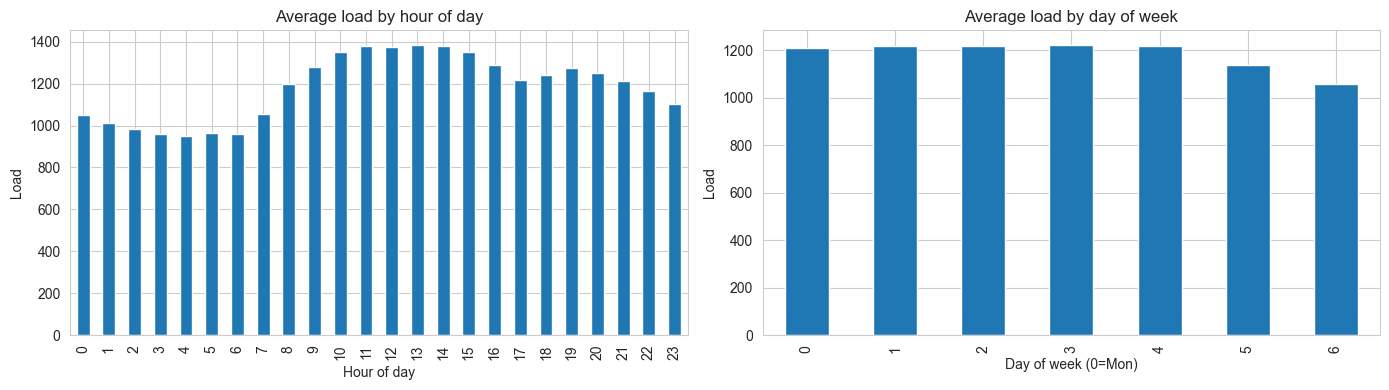

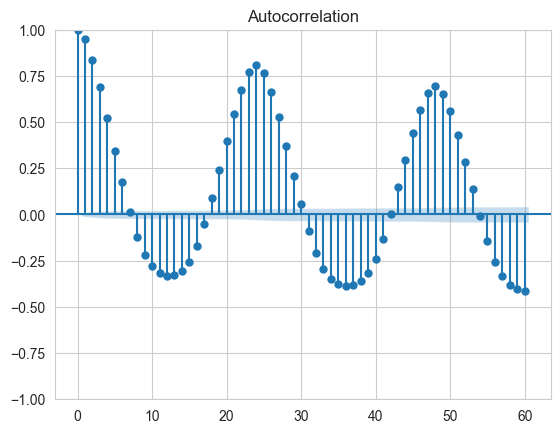

In [6]:
# 3) Average load by hour-of-day and day-of-week
df_feats = data.copy()
df_feats['hour'] = df_feats.index.hour
df_feats['dow'] = df_feats.index.dayofweek
hourly = df_feats.groupby('hour')['load'].mean()
dow = df_feats.groupby('dow')['load'].mean()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
hourly.plot(kind='bar', ax=ax1, title='Average load by hour of day')
ax1.set_xlabel('Hour of day')
ax1.set_ylabel('Load')
dow.plot(kind='bar', ax=ax2, title='Average load by day of week')
ax2.set_xlabel('Day of week (0=Mon)')
ax2.set_ylabel('Load')
plt.tight_layout()
plot_acf(data['load'].dropna(), lags=60)
plt.show()


- TODO: Inspect the previous plots and comment on the patterns you can distinguish

>>> Daily and weekly seasonality because it shows the electricity demand in Panama. Peak consumption between 11:00 AM and 3:00 PM and nighttime off-peaks, a pattern that is consistently repeated except on weekends, when demand decreases. There is high autocorrelation in 24-hour lags, preceding hours and days are key predictors.

## Section 2 — Turn time series into supervised learning data

We convert the time series into a tabular supervised problem: predict 1-step-ahead load from lag features, rolling statistics and calendar features.
Fill TODOs in the helper function below.

In [11]:
def make_supervised(df, target_col='load', horizon=1, lags=None):
    """Create supervised features for a 1-step-ahead forecast."""
    if lags is None:
        lags = [1, 24, 48, 168]  # t-1, t-24 (daily), t-48, t-168 (weekly)
    X = pd.DataFrame(index=df.index)
    # Lag features
    for lag in lags:
        X[f'lag_{lag}'] = df[target_col].shift(lag)
    # Rolling features: 24-hour and 7-day rolling mean/std
    X['rmean_24'] = df[target_col].rolling(window=24, min_periods=1).mean().shift(1)
    X['rstd_24'] = df[target_col].rolling(window=24, min_periods=1).std().shift(1)
    X['rmean_168'] = df[target_col].rolling(window=168, min_periods=1).mean().shift(1)
    # Calendar features
    X['hour'] = df.index.hour
    X['dow'] = df.index.dayofweek
    X['is_weekend'] = (X['dow'] >= 5).astype(int)
    X['month'] = df.index.month
    # Target (1-step ahead by default)
    y = df[target_col].shift(-horizon)
    # Align and drop NaNs caused by shifts
    X = X.loc[~y.isna()]
    y = y.loc[X.index]
    return X, y
# Build supervised data
X, y = make_supervised(data, target_col='load', horizon=1)
print('X shape:', X.shape, 'y shape:', y.shape)
# show a few rows
X.head()

X shape: (48047, 11) y shape: (48047,)


,lag_1,lag_24,lag_48,lag_168,rmean_24,rstd_24,rmean_168,hour,dow,is_weekend,month
datetime,,,,,,,,,,,
2015-01-03 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5,1,1
2015-01-03 02:00:00,970.3450,NaN,NaN,NaN,970.345000,NaN,970.345000,2,5,1,1
2015-01-03 03:00:00,912.1755,NaN,NaN,NaN,941.260250,41.132048,941.260250,3,5,1,1
2015-01-03 04:00:00,900.2688,NaN,NaN,NaN,927.596433,37.496964,927.596433,4,5,1,1
2015-01-03 05:00:00,889.9538,NaN,NaN,NaN,918.185775,35.938700,918.185775,5,5,1,1


## Section 3 — Time-based train / calibration / test split

Random splits leak future information in time series. We'll split chronologically: TRAIN (first 60%), CALIBRATION (next 20%), TEST (last 20%). The calibration set will be used for conformal prediction intervals.


In [12]:
# Chronological split
n = len(X)
i_train = int(n * 0.6)
i_cal = int(n * 0.8)
X_train = X.iloc[:i_train]
y_train = y.iloc[:i_train]
X_cal = X.iloc[i_train:i_cal]
y_cal = y.iloc[i_train:i_cal]
X_test = X.iloc[i_cal:]
y_test = y.iloc[i_cal:]
print('TRAIN range:', X_train.index.min(), 'to', X_train.index.max(), 'size', len(X_train))
print('CAL range:', X_cal.index.min(), 'to', X_cal.index.max(), 'size', len(X_cal))
print('TEST range:', X_test.index.min(), 'to', X_test.index.max(), 'size', len(X_test))

TRAIN range: 2015-01-03 01:00:00 to 2018-04-18 04:00:00 size 28828
CAL range: 2018-04-18 05:00:00 to 2019-05-23 13:00:00 size 9609
TEST range: 2019-05-23 14:00:00 to 2020-06-26 23:00:00 size 9610


## Section 4 — Baseline model and ML model

We compare a naive baseline (previous value) to a trained tree-based regressor. Evaluate using MAE and RMSE.


In [ ]:
# Naive baseline: predict using lag_1 (t-1). Align carefully.
y_test_index = y_test.index
# Baseline predictions: because target is t, naive is previous observed load at t-1 which is lag_1 feature
yhat_naive = X_test['lag_1']
# Fit a RandomForest as example ML model (students can replace with XGBoost/LGBM)
model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
# TODO: fit the model on (X_train, y_train)
# Handle NaN values in training data by dropping rows with any NaN
mask_train = ~X_train.isna().any(axis=1)
X_train_clean = X_train[mask_train]
y_train_clean = y_train[mask_train]
model.fit(X_train_clean, y_train_clean)
# Predict on test (handle NaN in test set too)
mask_test = ~X_test.isna().any(axis=1)
X_test_clean = X_test[mask_test]
yhat = pd.Series(model.predict(X_test_clean), index=X_test_clean.index)
# Evaluation
def evaluate(y_true, y_pred, label='model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**0.5
    print(f'{label} MAE: {mae:.3f}, RMSE: {rmse:.3f}')

evaluate(y_test, yhat_naive, label='Naive baseline')
# Align y_test with cleaned predictions
y_test_clean = y_test[mask_test]
evaluate(y_test_clean, yhat, label='RandomForest')
# Plot a selected TEST week: choose first week of test set
try:
    plot_start = X_test.index[0]
    plot_end = plot_start + pd.Timedelta(days=7)
    idx = (y_test.index >= plot_start) & (y_test.index < plot_end)
    plt.figure(figsize=(14, 4))
    plt.plot(y_test.loc[idx].index, y_test.loc[idx].values, label='true')
    plt.plot(yhat_naive.loc[idx].index, yhat_naive.loc[idx].values, label='naive')
    # Only plot model predictions where available (no NaN)
    idx_clean = idx & mask_test
    plt.plot(y_test.loc[idx_clean].index, yhat.loc[y_test.loc[idx_clean].index], label='model')
    plt.legend()
    plt.title('True vs Predictions (first test week)')
    plt.show()
except Exception as e:
    print('Could not plot test week:', e)

## Section 5 — Global and local XAI with SHAP

We use SHAP to explain feature importance globally and locally. For tree models, TreeExplainer is efficient. For other models, KernelExplainer may be used but is slower.


In [ ]:
# Select a subset of X_test for SHAP analysis (to keep compute small)
X_shap = X_test_clean.sample(n=min(500, len(X_test_clean)), random_state=RANDOM_SEED)
# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)
# Summary plot (beeswarm)
shap.summary_plot(shap_values, X_shap, show=True)
# Bar plot of mean absolute SHAP values
shap.summary_plot(shap_values, X_shap, plot_type='bar', show=True)
# Local explanation for a single interesting point (e.g., highest true load in test)
idx_max = y_test.idxmax()
print('Index with highest load in test:', idx_max)
x_local = X_test_clean.loc[[idx_max]]
try:
    sv_local = explainer.shap_values(x_local)
    shap.plots.waterfall(sv_local[0] if isinstance(sv_local, list) else sv_local, max_display=12)
except Exception as e:
    print('Could not produce local SHAP waterfall:', e)

- TODO: Interpret SHAP results, are there any innecessary inputs? Try to simplify the model and check performance variations. Does SHAP results match domain intuition?
>>> Your answer here

## Section 6 — Bootstrap ensemble for predictive variability

Train B bootstrap models (resampling training data with replacement) to approximate variability due to training data sampling. Use their distribution to produce prediction intervals.


In [ ]:
from copy import deepcopy
def bootstrap_models(X_train, y_train, base_model, B=10):
    models = []
    n = len(X_train)
    for b in range(B):
        idx = np.random.choice(np.arange(n), size=n, replace=True)
        Xb = X_train.iloc[idx]
        yb = y_train.iloc[idx]
        m = deepcopy(base_model)
        m.fit(Xb, yb)
        models.append(m)
    return models
# Train B bootstrap models (may take time)
B = 10
base = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# TODO: If running time is a concern reduce B or model complexity
models_b = bootstrap_models(X_train_clean, y_train_clean, base, B=B)
# Compute bootstrap predictions for X_test (may be memory heavy; sample a week for plotting)
def bootstrap_predict(models, X):
    preds = np.vstack([m.predict(X) for m in models])  # shape (B, n)
    return preds
preds_b = bootstrap_predict(models_b, X_test_clean)
# Mean and 5th-95th percentile interval
y_mean = preds_b.mean(axis=0)
y_p05 = np.percentile(preds_b, 5, axis=0)
y_p95 = np.percentile(preds_b, 95, axis=0)
# Plot a test week with bootstrap interval
try:
    plot_start = X_test_clean.index[0]
    plot_end = plot_start + pd.Timedelta(days=7)
    mask = (X_test_clean.index >= plot_start) & (X_test_clean.index < plot_end)
    plt.figure(figsize=(14, 4))
    plt.plot(y_test.loc[mask].index, y_test.loc[mask].values, label='true')
    plt.plot(X_test_clean.loc[mask].index, y_mean[mask], label='bootstrap mean')
    plt.fill_between(X_test_clean.loc[mask].index, y_p05[mask], y_p95[mask], color='C0', alpha=0.3, label='5-95%')
    plt.legend()
    plt.title('Bootstrap ensemble forecast and interval (first test week)')
    plt.show()
except Exception as e:
    print('Could not plot bootstrap week:', e)

## Section 7 — Conformal prediction intervals (inductive residual-based)

Inductive conformal uses residuals on a held-out calibration set to form a distribution of absolute errors; the quantile gives a symmetric interval around point predictions with finite-sample marginal coverage guarantees (under exchangeability).

In [ ]:
# --- Conformal quantile from calibration residuals ---
# Train a fresh model on TRAIN if desired. We'll reuse `model` already trained, but you can retrain here.
# model.fit(X_train, y_train)
# Predict on calibration set and compute residuals
# Handle NaN values in calibration set
mask_cal = ~X_cal.isna().any(axis=1)
X_cal_clean = X_cal[mask_cal]
yhat_cal = pd.Series(model.predict(X_cal_clean), index=X_cal_clean.index)
residuals = (y_cal[mask_cal] - yhat_cal).abs()
def conformal_q(residuals, alpha=0.1):
    """
    Compute conformal quantile with finite-sample correction:
    quantile at ceil((n+1)*(1-alpha))/n.
    """
    n = len(residuals)
    k = int(np.ceil((n + 1) * (1 - alpha))) - 1
    q = np.sort(residuals)[k]
    return q
alpha = 0.1
q_alpha = conformal_q(residuals.values, alpha=alpha)
print(f'Conformal q (alpha={alpha}):', q_alpha)
# --- Build intervals on TEST ---
yhat_test = pd.Series(model.predict(X_test_clean), index=X_test_clean.index)
lower = yhat_test - q_alpha
upper = yhat_test + q_alpha
# Evaluate empirical coverage and average width
inside = ((y_test >= lower) & (y_test <= upper)).mean()
avg_width = (upper - lower).mean()
print(f'Coverage on TEST (alpha={alpha}): {inside:.3f}, avg width: {avg_width:.3f}')
# Optionally loop over several alphas
alphas = [0.05, 0.1, 0.2]
rows = []
for a in alphas:
    q = conformal_q(residuals.values, alpha=a)
    yhat_test_a = pd.Series(model.predict(X_test_clean), index=X_test_clean.index)
    l = yhat_test_a - q
    u = yhat_test_a + q
    cov = ((y_test >= l) & (y_test <= u)).mean()
    rows.append({'alpha': a, 'q': q, 'coverage': cov, 'avg_width': (u - l).mean()})
conformal_summary = pd.DataFrame(rows)
print(conformal_summary)
# --- Plot conformal predictions along the time series (first 7 days of TEST) ---
import matplotlib.pyplot as plt
# Define plot window: first 7 days of the test period
plot_start = X_test_clean.index[0]
plot_end = plot_start + pd.Timedelta(days=7)
mask = (y_test.index >= plot_start) & (y_test.index <= plot_end)
y_test_plot = y_test[mask]
yhat_plot = yhat_test[mask]
lower_plot = lower[mask]
upper_plot = upper[mask]
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_test_plot.index, y_test_plot, label='Actual')
ax.plot(yhat_plot.index, yhat_plot, label='Prediction')
ax.fill_between(yhat_plot.index, lower_plot, upper_plot, alpha=0.3, label='Conformal interval')
ax.set_title(f'Conformal prediction interval on TEST (first 7 days, alpha={alpha})')
ax.set_xlabel('Time')
ax.set_ylabel('Load')
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


- TODO: Comment on the results, which you find more useful: bootstrap or conformal? Which would you use in case I ask you about uncertainty in forecasting models?
>>> Your comments here

## Section 9 — Using intervals for anomaly flagging

Flag times where true load lies outside conformal intervals — potentially anomalous events requiring operator attention.


In [ ]:
# Using alpha chosen earlier
yhat_test = pd.Series(model.predict(X_test_clean), index=X_test_clean.index)
lower = yhat_test - q_alpha
upper = yhat_test + q_alpha
anomaly = ~( (y_test >= lower) & (y_test <= upper) )
anomalies = pd.DataFrame({'y_true': y_test, 'yhat': yhat_test, 'lower': lower, 'upper': upper, 'anomaly': anomaly})
print('Number of anomalies in TEST:', anomalies['anomaly'].sum())
# Plot a test week with anomalies marked
try:
    mask = (X_test_clean.index >= X_test_clean.index[0]) & (X_test_clean.index < X_test_clean.index[0] + pd.Timedelta(days=7))
    plt.figure(figsize=(14, 4))
    plt.plot(anomalies.loc[mask].index, anomalies.loc[mask, 'y_true'], label='true')
    plt.plot(anomalies.loc[mask].index, anomalies.loc[mask, 'yhat'], label='yhat')
    plt.fill_between(anomalies.loc[mask].index, anomalies.loc[mask, 'lower'], anomalies.loc[mask, 'upper'], color='C0', alpha=0.2)
    # mark anomalies
    an_idx = anomalies.loc[mask & anomalies['anomaly']].index
    plt.scatter(an_idx, anomalies.loc[an_idx, 'y_true'], color='red', label='anomaly')
    plt.legend()
    plt.title('Test week with conformal band and anomalies')
    plt.show()
except Exception as e:
    print('Could not plot anomalies:', e)
# Print a small table of anomalies (timestamp, y_true, yhat, lower, upper)
anomalies[anomalies['anomaly']].head(20)

- TODO: Are the anomalies true grid events or model errors? Justify your answer
>>> Your answer here

## Section 10 — Visualizing

- How would you present these results to non-technical stakeholders at a grid operator? Include visuals and short bullet recommendations. Add as many code and markdown cells as you find necessary.
